In [1]:
# Provides ways to work with large multidimensional arrays
import numpy as np 
# Allows for further data manipulation and analysis
import pandas as pd
from pandas_datareader import data # Reads stock data 
import matplotlib.pyplot as plt # Plotting
import matplotlib.dates as mdates # Styling dates
%matplotlib inline

import datetime as dt # For defining dates
# import mplfinance as mpf # Matplotlib finance

import time

# Used to get data from a directory
import os
from os import listdir
from os.path import isfile, join

#Statsmodels is a great library we can use to run regressions.
import statsmodels.api as sm
# Seaborn extends the capabilities of Matplotlib
import seaborn as sns
# Used for calculating regressions
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [2]:
#change the tickers here according to what's in the portfolio
tickers = ["AAPL", "TSLA", 'MSFT', 'AMZN', 'EBAY', 'FB', "GNRC", "CPRT", "ODFL"]

start_date = '2013-01-01'
end_date = '2022-01-01'

panel_data = data.DataReader(tickers,'yahoo', start_date, end_date)

In [3]:
#check that all stocks have the same amount of data otherwise change the date range

adj_close = panel_data['Adj Close']
adj_close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2268 entries, 2012-12-31 to 2021-12-31
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    2268 non-null   float64
 1   TSLA    2268 non-null   float64
 2   MSFT    2268 non-null   float64
 3   AMZN    2268 non-null   float64
 4   EBAY    2268 non-null   float64
 5   FB      2268 non-null   float64
 6   GNRC    2268 non-null   float64
 7   CPRT    2268 non-null   float64
 8   ODFL    2268 non-null   float64
dtypes: float64(9)
memory usage: 177.2 KB


## Function that saves dataframe to CSV

In [4]:
def save_dataframe_to_csv(kind, df, ticker):
    df.to_csv(kind + ticker + '.csv')

In [5]:
# for ticker in tickers:
#     panel_data = data.DataReader(ticker,'yahoo', start_date, end_date)
#     close = panel_data['Close']
#     adj_close = panel_data['Adj Close']
#     save_dataframe_to_csv('adj_close', adj_close, ticker)

## Function that returns dataframe from a CSV

In [6]:
def get_df_from_csv(kind, ticker):
    try:
        df = pd.read_csv(kind + ticker + '.csv', index_col='Date', 
                         parse_dates=True)
    except FileNotFoundError:
        pass
        # print("File Doesn't Exist")
    else:
        return df

## Add Daily Return to dataframe

In [7]:
def add_daily_return_to_df(kind, df, ticker):
    df['daily_return'] = (df['Adj Close'] / df['Adj Close'].shift(1)) - 1
    # Save data to a CSV file
    save_dataframe_to_csv(kind, df, ticker)
    return df

In [8]:
for ticker in tickers:
    df = get_df_from_csv('adj_close', ticker)
    add_daily_return_to_df('adj_close', df, ticker)

## Merge multiple stocks in one dataframe by col name

In [9]:
def merge_df_by_column_name(col_name, sdate, edate, *tickers):
    # Will hold data for all dataframes with the same column name
    mult_df = pd.DataFrame()
    
    for x in tickers:
        df = get_df_from_csv('adj_close', x)
        
        # NEW Check if your dataframe has duplicate indexes
        if not df.index.is_unique:
            # Delete duplicates 
            df = df.loc[~df.index.duplicated(), :]
        
        mask = (df.index >= sdate) & (df.index <= edate)
        mult_df[x] = df.loc[mask][col_name]
        
    return mult_df

## Get stock prices on date

In [10]:
def get_prices_on_date(stocks_df, date):
    return stocks_df.loc[pd.DatetimeIndex([date])]['Adj Close'].item()

## Returns the value of portfolio by date

In [11]:
def get_port_val_by_date(date, shares, tickers):
    port_prices = merge_df_by_column_name('Adj Close',  date, date, *port_list)
    # Convert from dataframe to Python list
    port_prices = port_prices.values.tolist()
    # Trick that converts a list of lists into a single list
    port_prices = sum(port_prices, [])
    
    # Create a list of values by multiplying shares by price
    value_list = []
    for price, share in zip(port_prices, shares):
        value_list.append(price * share)
    
    return sum(value_list)

## Find Daily Return for Whole Portfolio

In [12]:
def get_port_daily_return(sdate, edate, shares, tickers):
    # Merge all daily prices for all stocks into 1 dataframe
    mult_df = merge_df_by_column_name('Adj Close',  sdate, 
                                  edate, *port_list)
    
    # Get the number of stocks in portfolio
    num_cols = len(mult_df.columns)
    
    # Multiply each stock column by the number of shares
    i = 0
    while i < num_cols:
        mult_df[tickers[i]] = mult_df[tickers[i]].apply(lambda x: x * shares[i])
        i += 1
        
    # Create a new column with the sums of all stocks named Total
    mult_df['Total'] = mult_df.iloc[:, 0:num_cols].sum(axis=1)
    
    # Add column for portfolio daily return
    mult_df['daily_return'] = (mult_df['Total'] / mult_df['Total'].shift(1)) - 1
    
    return mult_df

In [13]:
#change to the list of stocks we using
port_list = ["AAPL", "TSLA", 'MSFT', 'AMZN', 'EBAY', 'FB', "GNRC", "CPRT", "ODFL"]

#add in the weightage of stocks
port_shares = [0.1101,0.1,0.0883,0.0988,0.1673,0.1872,0.1433,0.0655,0.0395]

# tot_port_df = get_port_daily_return('2020-01-02', '2020-12-31', 
#                                     port_shares, port_list)

#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2013-01-01', '2017-01-01', port_shares, port_list)
tot_port_df

,AAPL,TSLA,MSFT,AMZN,EBAY,FB,GNRC,CPRT,ODFL,Total,daily_return
Date,,,,,,,,,,,
2013-01-02,1.864996,0.7072,2.025660,25.422228,3.609268,5.241600,4.427967,0.997565,0.916774,45.213257,NaN
2013-01-03,1.841457,0.6954,1.998524,25.537825,3.532489,5.198544,4.356264,0.990360,0.906969,45.057831,-0.003438
2013-01-04,1.790163,0.6880,1.961120,25.604019,3.554714,5.383872,4.366327,0.998220,0.917032,45.263468,0.004564
2013-01-07,1.779633,0.6868,1.957453,26.523847,3.603880,5.507424,4.361295,1.009682,0.922967,46.352980,0.024070
2013-01-08,1.784422,0.6736,1.947185,26.318344,3.547980,5.440032,4.357521,0.996910,0.906969,45.972964,-0.008198
...,...,...,...,...,...,...,...,...,...,...,...
2016-12-23,3.015050,4.2668,5.181254,75.146295,4.767078,21.952943,6.031497,1.819262,2.241749,124.421928,-0.003748
2016-12-27,3.034198,4.3906,5.184530,76.214322,4.839088,22.091472,6.037229,1.834327,2.250005,125.875772,0.011685
2016-12-28,3.021260,4.3948,5.160771,76.286444,4.802283,21.887424,5.905393,1.819262,2.210785,125.488423,-0.003077


## Get old data for portfolio

In [14]:
#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2013-01-01', '2017-01-01', 
                                    port_shares, port_list)
tot_port_df

,AAPL,TSLA,MSFT,AMZN,EBAY,FB,GNRC,CPRT,ODFL,Total,daily_return
Date,,,,,,,,,,,
2013-01-02,1.864996,0.7072,2.025660,25.422228,3.609268,5.241600,4.427967,0.997565,0.916774,45.213257,NaN
2013-01-03,1.841457,0.6954,1.998524,25.537825,3.532489,5.198544,4.356264,0.990360,0.906969,45.057831,-0.003438
2013-01-04,1.790163,0.6880,1.961120,25.604019,3.554714,5.383872,4.366327,0.998220,0.917032,45.263468,0.004564
2013-01-07,1.779633,0.6868,1.957453,26.523847,3.603880,5.507424,4.361295,1.009682,0.922967,46.352980,0.024070
2013-01-08,1.784422,0.6736,1.947185,26.318344,3.547980,5.440032,4.357521,0.996910,0.906969,45.972964,-0.008198
...,...,...,...,...,...,...,...,...,...,...,...
2016-12-23,3.015050,4.2668,5.181254,75.146295,4.767078,21.952943,6.031497,1.819262,2.241749,124.421928,-0.003748
2016-12-27,3.034198,4.3906,5.184530,76.214322,4.839088,22.091472,6.037229,1.834327,2.250005,125.875772,0.011685
2016-12-28,3.021260,4.3948,5.160771,76.286444,4.802283,21.887424,5.905393,1.819262,2.210785,125.488423,-0.003077


## Forecasting

In [15]:
tot_port_df = tot_port_df.asfreq('d')
tot_port_df.index

DatetimeIndex(['2013-01-02', '2013-01-03', '2013-01-04', '2013-01-05',
               '2013-01-06', '2013-01-07', '2013-01-08', '2013-01-09',
               '2013-01-10', '2013-01-11',
               ...
               '2016-12-21', '2016-12-22', '2016-12-23', '2016-12-24',
               '2016-12-25', '2016-12-26', '2016-12-27', '2016-12-28',
               '2016-12-29', '2016-12-30'],
              dtype='datetime64[ns]', name='Date', length=1459, freq='D')

In [16]:
# Delete NaNs for nontrading days
tot_port_df = tot_port_df.fillna(method='ffill')

In [17]:
tot_port_df

,AAPL,TSLA,MSFT,AMZN,EBAY,FB,GNRC,CPRT,ODFL,Total,daily_return
Date,,,,,,,,,,,
2013-01-02,1.864996,0.7072,2.025660,25.422228,3.609268,5.241600,4.427967,0.997565,0.916774,45.213257,NaN
2013-01-03,1.841457,0.6954,1.998524,25.537825,3.532489,5.198544,4.356264,0.990360,0.906969,45.057831,-0.003438
2013-01-04,1.790163,0.6880,1.961120,25.604019,3.554714,5.383872,4.366327,0.998220,0.917032,45.263468,0.004564
2013-01-05,1.790163,0.6880,1.961120,25.604019,3.554714,5.383872,4.366327,0.998220,0.917032,45.263468,0.004564
2013-01-06,1.790163,0.6880,1.961120,25.604019,3.554714,5.383872,4.366327,0.998220,0.917032,45.263468,0.004564
...,...,...,...,...,...,...,...,...,...,...,...
2016-12-26,3.015050,4.2668,5.181254,75.146295,4.767078,21.952943,6.031497,1.819262,2.241749,124.421928,-0.003748
2016-12-27,3.034198,4.3906,5.184530,76.214322,4.839088,22.091472,6.037229,1.834327,2.250005,125.875772,0.011685
2016-12-28,3.021260,4.3948,5.160771,76.286444,4.802283,21.887424,5.905393,1.819262,2.210785,125.488423,-0.003077


In [18]:
# Delete all unneeded columns - basically delete all except Total
del_col = ["AAPL", "TSLA", 'MSFT', 'AMZN', 'EBAY', 'FB', "GNRC", "CPRT", "ODFL", "daily_return"]

for x in del_col:
    tot_port_df = tot_port_df.drop([x], axis=1)

In [19]:
tot_port_df

,Total
Date,
2013-01-02,45.213257
2013-01-03,45.057831
2013-01-04,45.263468
2013-01-05,45.263468
2013-01-06,45.263468
...,...
2016-12-26,124.421928
2016-12-27,125.875772
2016-12-28,125.488423


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use t

Lags : [1]
Observations : 1459


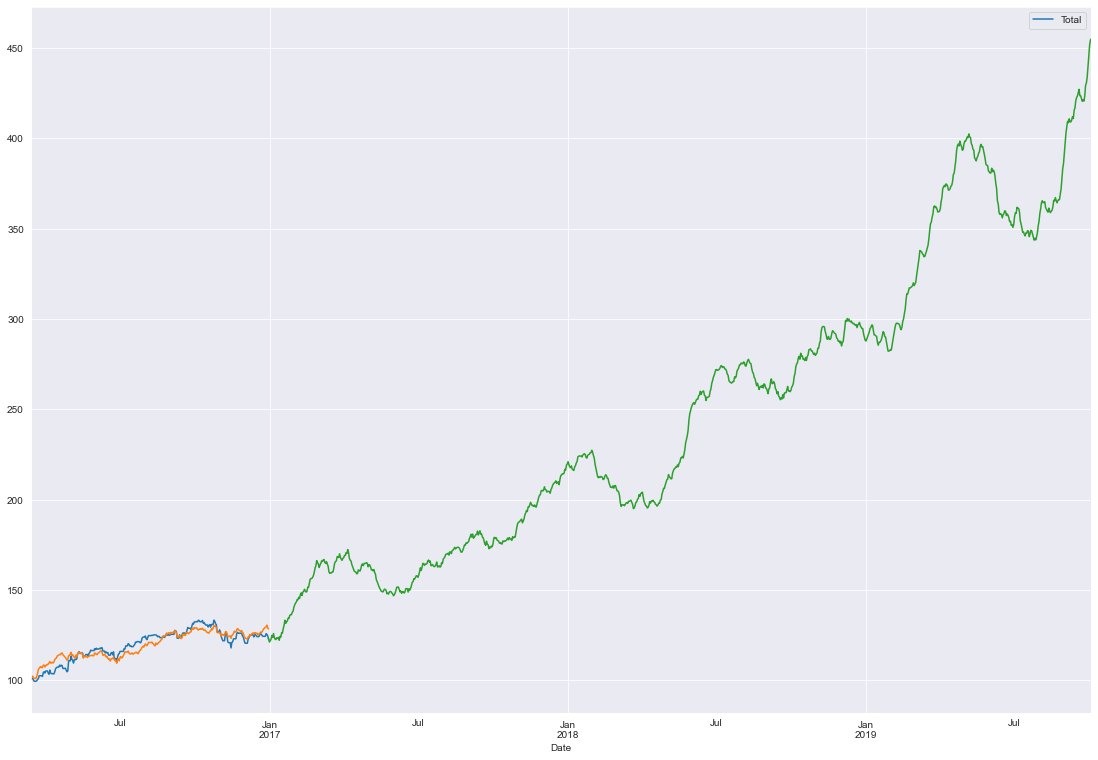

In [20]:
# Set style for seaborn plot
sns.set_style('darkgrid')
# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(19, 13))

# Set fig and ax
fig, ax = plt.subplots()

# Figure out optimum lags for this data set
lags = ar_select_order(tot_port_df, maxlag=30)
print("Lags :", lags.ar_lags)

# Create our model using whole data set
model = AutoReg(tot_port_df['Total'], lags.ar_lags)
model_fit = model.fit()

# Define training and testing area
print("Observations :", len(tot_port_df)) # 1095 observations

train_df = tot_port_df.iloc[0:1167] # First 80% 
test_df = tot_port_df.iloc[1167:] # Last 20%

# Define training model for 459 days (Play with Number & Test)
# and White's covariance estimator
train_model = AutoReg(tot_port_df['Total'], 459).fit(cov_type="HC0")

# # Define start and end for prediction 
start = len(train_df)
end = len(train_df) + len(test_df) - 1

prediction = train_model.predict(start=start, end=end, dynamic=True)

# Plot testing data with prediction
ax = test_df.plot(ax=ax) # blue
ax = prediction.plot(ax=ax) # orange

# Predict 60 days into the future
forecast = train_model.predict(start=end, end=end+1008, dynamic=True)
ax = forecast.plot(ax=ax) # Green

## Calculate annualized returns for forecasted

In [21]:
forecast

2016-12-30    123.265619
2016-12-31    121.295405
2017-01-01    121.936097
2017-01-02    122.821622
2017-01-03    124.874436
                 ...    
2019-09-30    439.724142
2019-10-01    445.863978
2019-10-02    451.633848
2019-10-03    454.410632
2019-10-04    455.017967
Freq: D, Length: 1009, dtype: float64

In [22]:
forecast_df = pd.DataFrame(forecast)

In [23]:
forecast_df

,0
2016-12-30,123.265619
2016-12-31,121.295405
2017-01-01,121.936097
2017-01-02,122.821622
2017-01-03,124.874436
...,...
2019-09-30,439.724142
2019-10-01,445.863978
2019-10-02,451.633848
2019-10-03,454.410632


In [24]:
return_series = (1 + forecast_df.pct_change()).cumprod() - 1

In [25]:
return_series

,0
2016-12-30,NaN
2016-12-31,-0.015983
2017-01-01,-0.010786
2017-01-02,-0.003602
2017-01-03,0.013052
...,...
2019-09-30,2.567289
2019-10-01,2.617099
2019-10-02,2.663908
2019-10-03,2.686434


In [26]:
#calculate annualized return
total_return = return_series.tail(1)

annualized_return = ((1 + total_return)**(1/4))-1

print(annualized_return*100)

                    0
2019-10-04  38.610665


## Backtesting

In [27]:
tickers2 = ["AAPL", "TSLA", 'MSFT', 'AMZN', 'EBAY', 'FB', "GNRC", "CPRT", "ODFL"]

#change the date according to the year you want to backtest and compare with forecasted
start_date = '2017-01-01'
end_date = '2021-01-05'

panel_data2 = data.DataReader(tickers2,'yahoo', start_date, end_date)

In [28]:
panel_data2 = panel_data2['Adj Close']

In [29]:
panel_data2

Symbols,AAPL,TSLA,MSFT,AMZN,EBAY,FB,GNRC,CPRT,ODFL
Date,,,,,,,,,
2017-01-03,27.297689,43.397999,58.065453,753.669983,28.542013,116.860001,41.939999,27.860001,56.687790
2017-01-04,27.267138,45.397999,57.805656,757.179993,28.465494,118.690002,42.000000,28.230000,56.922962
2017-01-05,27.405798,45.349998,57.805656,780.450012,28.704620,120.669998,41.119999,28.200001,56.250130
2017-01-06,27.711334,45.801998,58.306694,795.989990,29.699379,123.410004,40.709999,28.340000,56.243603
2017-01-09,27.965151,46.256001,58.121132,796.919983,29.412430,124.900002,40.290001,28.264999,55.936581
...,...,...,...,...,...,...,...,...,...
2020-12-29,133.873093,665.989990,221.828049,3322.000000,50.092426,276.779999,221.369995,125.919998,193.382706
2020-12-30,132.731567,694.780029,219.383621,3285.850098,49.787102,271.869995,229.190002,126.540001,192.874649
2020-12-31,131.709198,705.669983,220.115967,3256.929932,49.491631,273.160004,227.410004,127.250000,194.428650


## Portfolio Analysis

In [30]:
return_series2 = panel_data2.pct_change().dropna()
return_series2.head()

Symbols,AAPL,TSLA,MSFT,AMZN,EBAY,FB,GNRC,CPRT,ODFL
Date,,,,,,,,,
2017-01-04,-0.001119,0.046085,-0.004474,0.004657,-0.002681,0.015660,0.001431,0.013281,0.004149
2017-01-05,0.005085,-0.001057,0.000000,0.030732,0.008401,0.016682,-0.020952,-0.001063,-0.011820
2017-01-06,0.011149,0.009967,0.008668,0.019912,0.034655,0.022707,-0.009971,0.004965,-0.000116
2017-01-09,0.009159,0.009912,-0.003183,0.001168,-0.009662,0.012074,-0.010317,-0.002646,-0.005459
2017-01-10,0.001008,-0.006097,-0.000319,-0.001280,-0.016260,-0.004404,0.012162,0.003184,0.012379


In [31]:
portfolio_weights = [0.1101,0.1,0.0883,0.0988,0.1673,0.1872,0.1433,0.0655,0.0395]

#apply the weights to returns
wt_portfolio = return_series2 * portfolio_weights
wt_portfolio.head()

Symbols,AAPL,TSLA,MSFT,AMZN,EBAY,FB,GNRC,CPRT,ODFL
Date,,,,,,,,,
2017-01-04,-0.000123,0.004609,-0.000395,0.000460,-0.000449,0.002932,0.000205,0.000870,0.000164
2017-01-05,0.000560,-0.000106,0.000000,0.003036,0.001405,0.003123,-0.003002,-0.000070,-0.000467
2017-01-06,0.001227,0.000997,0.000765,0.001967,0.005798,0.004251,-0.001429,0.000325,-0.000005
2017-01-09,0.001008,0.000991,-0.000281,0.000115,-0.001616,0.002260,-0.001478,-0.000173,-0.000216
2017-01-10,0.000111,-0.000610,-0.000028,-0.000126,-0.002720,-0.000824,0.001743,0.000209,0.000489


In [32]:
portfolio_returns1 = wt_portfolio.sum(axis = 1)
portfolio_returns1.head()

Date
2017-01-04    0.008272
2017-01-05    0.004480
2017-01-06    0.013897
2017-01-09    0.000610
2017-01-10   -0.001758
dtype: float64

/opt/anaconda3/lib/python3.8/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


Start date,2017-01-04
End date,2021-01-05
Total months,48
,Backtest
Annual return,45.2%
Cumulative returns,344.7%
Annual volatility,24.6%
Sharpe ratio,1.64
Calmar ratio,1.43
Stability,0.86
Max drawdown,-31.6%


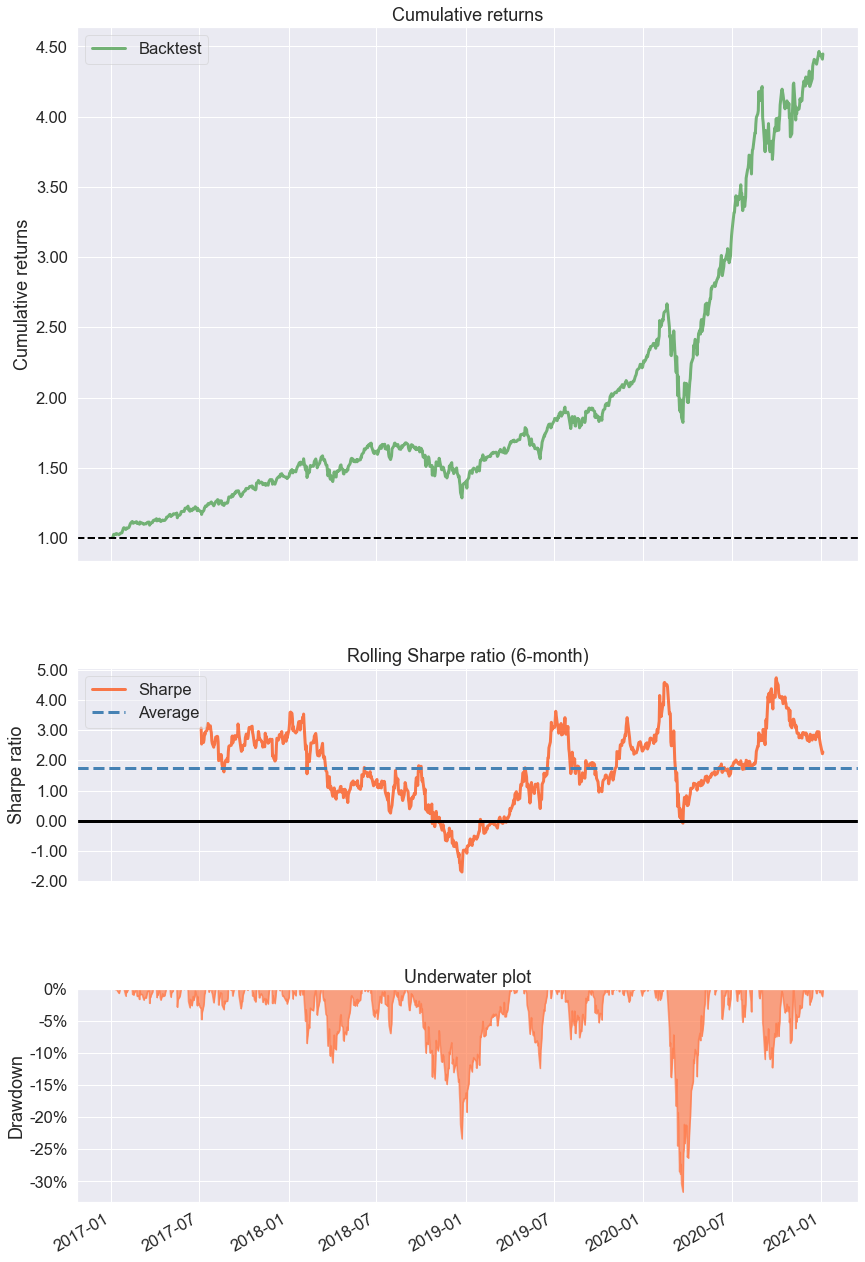

In [33]:
import pyfolio as pf
pf.create_simple_tear_sheet(portfolio_returns1)

## Extra stuff

In [34]:
import itertools

In [35]:
weights = [0.1101,0.1,0.0883,0.0988,0.1673,0.1872,0.1433,0.0655,0.0395]

In [36]:
panel_data2 = panel_data2 * weights

In [37]:
num_cols = len(panel_data2.columns)
    
# Create a new column with the sums of all stocks named Total
panel_data2['Total'] = panel_data2.iloc[:, 0:num_cols].sum(axis=1)

In [38]:
#forecasted portfolio value
panel_data2

Symbols,AAPL,TSLA,MSFT,AMZN,EBAY,FB,GNRC,CPRT,ODFL,Total
Date,,,,,,,,,,
2017-01-03,3.005476,4.339800,5.127179,74.462594,4.775079,21.876192,6.010002,1.824830,2.239168,123.660320
2017-01-04,3.002112,4.539800,5.104239,74.809383,4.762277,22.218768,6.018600,1.849065,2.248457,124.552702
2017-01-05,3.017378,4.535000,5.104239,77.108461,4.802283,22.589424,5.892496,1.847100,2.221880,127.118262
2017-01-06,3.051018,4.580200,5.148481,78.643811,4.968706,23.102353,5.833743,1.856270,2.221622,129.406204
2017-01-09,3.078963,4.625600,5.132096,78.735694,4.920700,23.381280,5.773557,1.851357,2.209495,129.708743
...,...,...,...,...,...,...,...,...,...,...
2020-12-29,14.739428,66.598999,19.587417,328.213600,8.380463,51.813216,31.722320,8.247760,7.638617,536.941819
2020-12-30,14.613746,69.478003,19.371574,324.641990,8.329382,50.894063,32.842927,8.288370,7.618549,536.078603
2020-12-31,14.501183,70.566998,19.436240,321.784677,8.279950,51.135553,32.587854,8.334875,7.679932,534.307261


In [39]:
actual_portfolio_value = []

for value in panel_data2['Total']:
    actual_portfolio_value.append(value)

In [40]:
actual_portfolio_value

[123.66031972427366,
 124.5527020679474,
 127.1182615354538,
 129.40620380477904,
 129.70874273662565,
 129.50172671279907,
 130.22855999145509,
 131.7234754684448,
 132.17843662834167,
 131.2187734140396,
 131.13222825469973,
 131.39476191082002,
 131.3437638277054,
 132.67254172306062,
 133.58870967903135,
 135.5989503440857,
 136.34074014511106,
 136.10443785037995,
 135.09326313762662,
 134.23002227687837,
 135.71598280086513,
 135.94845525074007,
 133.2517232318878,
 133.3526847673416,
 133.94250647888182,
 135.29060215244294,
 135.85545721378327,
 136.65199828777313,
 137.950765791893,
 137.51689008922577,
 138.25314866828919,
 138.13700501594545,
 138.302416831398,
 139.62802595691682,
 139.88417951717378,
 138.93483732452393,
 138.2628923151016,
 138.69268924350737,
 138.02029832839963,
 139.5922421331406,
 138.83054486980436,
 139.00110084400177,
 138.69658686409,
 138.47735563564302,
 138.88875873680115,
 139.0698635139465,
 139.1816491062164,
 139.59599729042054,
 139.342799

In [41]:
forecasted_portfolio_value = []

for value in forecast_df[0]:
    forecasted_portfolio_value.append(value)

In [42]:
forecasted_portfolio_value

[123.26561939047276,
 121.29540520712351,
 121.9360971886228,
 122.82162217593465,
 124.87443635294015,
 123.76281326565937,
 125.95734117414537,
 123.90069683808008,
 122.87134513273926,
 122.61836528411082,
 123.6439101102354,
 123.35478499028365,
 123.76097449141072,
 122.23988237187515,
 124.44925041823976,
 123.9915172215646,
 126.48131131200267,
 126.25890636496493,
 128.80332408414873,
 130.50686740243208,
 133.31890330125034,
 131.5979282572197,
 132.45740878087005,
 132.9479759552668,
 134.46710027887366,
 134.3460941504471,
 136.0088355789908,
 136.4301609332791,
 136.37434977153123,
 137.69783890541487,
 138.31487477183845,
 140.59002788743067,
 141.78666902525123,
 142.80159222771636,
 143.41495381452444,
 144.7574114521978,
 144.67201844040554,
 146.017257749659,
 145.37696011759715,
 147.66528201803118,
 148.48639448491195,
 146.98197142384296,
 148.9107055951774,
 149.30195120237627,
 150.4503900986116,
 149.5229138891804,
 148.8770450192882,
 149.33932904006673,
 151.63

## Calculate MAPE of forecasted period

In [43]:
# Define the dataset as python lists
# actual = [136, 120, 138, 155, 149]
# forecast = [134, 124, 132, 141, 149]

# Consider a list APE to store the
# APE value for each of the records in dataset
APE = []

# Iterate over the list values
for day in range(253):

	# Calculate percentage error
	per_err = (actual_portfolio_value[day] - forecasted_portfolio_value[day]) / actual_portfolio_value[day]

	# Take absolute value of
	# the percentage error (APE)
	per_err = abs(per_err)

	# Append it to the APE list
	APE.append(per_err)

# Calculate the MAPE
MAPE = sum(APE)/len(APE)

# Print the MAPE value and percentage
print(f'''
MAPE : { round(MAPE, 2) }
MAPE % : { round(MAPE*100, 2) } %
''')


MAPE : 0.06
MAPE % : 6.27 %



In [44]:
from sklearn.metrics import mean_squared_error
from math import sqrt
print(sqrt(mean_squared_error(actual_portfolio_value, forecasted_portfolio_value)))

49.42437092434568
